# Adam

Adam 在 RMSProp 基础上对小批量随机梯度也做了指数加权移动平均 [1]。下面我们来介绍这个算法。

## 算法

Adam 使用了动量变量 $\boldsymbol{v}_t$ 和 RMSProp 中小批量随机梯度按元素平方的指数加权移动平均变量 $\boldsymbol{s}_t$，并在时间步 0 将它们中每个元素初始化为 0。给定超参数 $0 \leq \beta_1 < 1$（算法作者建议设为 0.9），时间步 $t$ 的动量变量 $\boldsymbol{v}_t$ 即小批量随机梯度 $\boldsymbol{g}_t$ 的指数加权移动平均：

$$\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t. $$

和 RMSProp 中一样，给定超参数 $0 \leq \beta_2 < 1$（算法作者建议设为 0.999），
将小批量随机梯度按元素平方后的项 $\boldsymbol{g}_t \odot \boldsymbol{g}_t$ 做指数加权移动平均得到 $\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

由于我们将 $\boldsymbol{v}_0$ 和 $\boldsymbol{s}_0$ 中的元素都初始化为 0，
在时间步 $t$ 我们得到 $\boldsymbol{v}_t =  (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i$。将过去各时间步小批量随机梯度的权值相加，得到 $(1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$。需要注意的是，当 $t$ 较小时，过去各时间步小批量随机梯度权值之和会较小。例如当 $\beta_1 = 0.9$ 时，$\boldsymbol{v}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步 $t$，我们可以将 $\boldsymbol{v}_t$ 再除以 $1 - \beta_1^t$，从而使得过去各时间步小批量随机梯度权值之和为 1。这也叫做偏差修正。在 Adam 算法中，我们对变量 $\boldsymbol{v}_t$ 和 $\boldsymbol{s}_t$ 均作偏差修正：

$$\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t}, $$

$$\hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}. $$


接下来，Adam 算法使用以上偏差修正后的变量 $\hat{\boldsymbol{v}}_t$ 和 $\hat{\boldsymbol{s}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：

$$\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t + \epsilon}},$$

其中 $\eta$ 是学习率，$\epsilon$ 是为了维持数值稳定性而添加的常数，例如 $10^{-8}$。和 Adagrad、RMSProp 以及 Adadelta 一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用 $\boldsymbol{g}_t'$ 迭代自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'. $$

## 从零开始实现

我们按照算法中的公式实现 Adam。其中时间步 $t$ 通过`hyperparams`参数传入`adam`函数。

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import nd

features, labels = d2l.get_data_ch7()

def init_adam_states():
    v_w, v_b = nd.zeros((features.shape[1], 1)), nd.zeros(1)
    s_w, s_b = nd.zeros((features.shape[1], 1)), nd.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad
        s[:] = beta2 * s + (1 - beta2) * p.grad.square()
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p[:] -= hyperparams['lr'] * v_bias_corr / (s_bias_corr.sqrt() + eps)
    hyperparams['t'] += 1

使用学习率 $0.01$ 的 Adam 来训练模型。

loss: 0.244979, 0.512036 sec per epoch


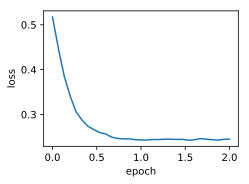

In [2]:
d2l.train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features,
              labels)

## 简洁实现

通过算法名称为“adam”的`Trainer`实例，我们便可在 Gluon 中使用 Adam 算法。

loss: 0.243485, 0.239465 sec per epoch


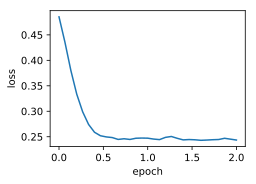

In [3]:
d2l.train_gluon_ch7('adam', {'learning_rate': 0.01}, features, labels)

## 小结

* Adam 在 RMSProp 基础上对小批量随机梯度也做了指数加权移动平均。
* Adam 使用了偏差修正。

## 练习

* 调节学习率，观察并分析实验结果。
* 有人说 Adam 是 RMSProp 与动量法的结合。想一想，这是为什么？


## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/2279)

![](../img/qr_adam.svg)

## 参考文献

[1] Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.